# Hyperparameter tuning

## Imports

In [1]:
from inspect import signature

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score, matthews_corrcoef,
                             precision_score, recall_score)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

d:\Anaconda\envs\PGM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Load and Split

In [2]:
x_df = pd.read_csv('..\\data\\features5.csv')
y_df = pd.read_csv('..\\data\\labels.csv')

display(x_df.head())
display(y_df.head())

,username,link_karma,comment_karma,account_age,is_verified,avg_cosine_similarity,all_users_similarity,avg_comment_length,max_comment_length,min_comment_length,comment_post_ratio,avg_thread_depth,parent_child_similarity,avg_ttr,avg_flesch_kincaid_grade,ngram_overlap,avg_score,avg_num_replies
0,yakfsh1,19830.0,88232.0,1440.0,True,1.0,0.019249,368.00,368.0,368.0,1.0,0.666667,0.030395,0.955981,9.20000,0.002070,1173.666667,2.111111
1,Tsquare43,699100.0,720902.0,3636.0,True,1.0,0.015121,62.00,62.0,62.0,1.0,1.619048,0.037736,0.955845,7.07619,0.000198,26.571429,0.333333
2,SeaSpeakToMe,236.0,11628.0,1029.0,True,NaN,0.012001,90.25,141.0,64.0,1.0,1.000000,0.121246,1.000000,1.30000,0.000000,3.000000,0.000000
3,hurtingxliving,848.0,1275.0,2001.0,True,NaN,0.014932,37.00,37.0,37.0,1.0,0.000000,0.000000,0.888889,12.60000,0.000000,6.000000,0.000000
4,Minute-Photo6916,1.0,4.0,12.0,True,NaN,0.008529,15.00,15.0,15.0,1.0,1.000000,0.000000,1.000000,-2.30000,0.000000,5.000000,0.000000


,username,is_bot
0,yakfsh1,False
1,Tsquare43,False
2,SeaSpeakToMe,False
3,hurtingxliving,False
4,Minute-Photo6916,False


In [3]:
def create_balanced_dataset(y_df, x_df, bot_ratio=0.4):
    merged_df = pd.merge(y_df, x_df, on='username')
    bot_users = merged_df[merged_df['is_bot'] == True]

    num_bots = len(bot_users)
    num_non_bots = int((num_bots / bot_ratio) - num_bots)
    non_bot_users = merged_df[merged_df['is_bot'] == False].sample(n=num_non_bots, random_state=30)
    balanced_df = pd.concat([bot_users, non_bot_users])

    new_y_df = balanced_df[['username', 'is_bot']]
    new_x_df = balanced_df.drop(columns=['is_bot'])
    
    return new_x_df, new_y_df

In [4]:
X_df_balanced, y_df_balanced = create_balanced_dataset(y_df, x_df)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_df_balanced, y_df_balanced, test_size=0.2, random_state=30, stratify=y_df_balanced['is_bot'])

In [6]:
X_train = X_train.sort_values(by='username')
y_train = y_train.sort_values(by='username')
X_test = X_test.sort_values(by='username')
y_test = y_test.sort_values(by='username')

## Data preprocessing

In [7]:
def drop_columns(X, columns):
    return X.drop(columns, axis=1)


def replace_none(X, column_value_pairs):
    for column, value in column_value_pairs.items():
        X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)
    return X

def convert_bool(X, columns):
    for column in columns:
        X.loc[:, column] = X[column].apply(lambda x: 1 if x else 0)
    return X


def drop_rows_with_none(X, columns):
    return X.dropna(subset=columns)


In [8]:
class CustomStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_standardize):
        self.columns_to_standardize = columns_to_standardize
        self.standard_scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='constant', fill_value=1)

    def fit(self, X, y=None):
        X = X.copy()
        without_none = X.dropna(subset=self.columns_to_standardize)
        self.standard_scaler.fit(without_none[self.columns_to_standardize])
        self.imputer.fit(X[self.columns_to_standardize])
        return self

    def transform(self, X, y=None):
        without_none = X.dropna(subset=self.columns_to_standardize)
        with_none = X[~X.index.isin(without_none.index)]
        X_standardized = self.standard_scaler.transform(without_none[self.columns_to_standardize])
        X_combined = np.hstack([X_standardized, without_none.drop(columns=self.columns_to_standardize, axis=1)])
        X_combined_df = pd.DataFrame(X_combined, index=without_none.index, columns=list(self.columns_to_standardize) + list(without_none.drop(columns=self.columns_to_standardize, axis=1).columns))
        X_final = pd.concat([X_combined_df, with_none], axis=0).sort_index()
        X_final[self.columns_to_standardize] = self.imputer.transform(X_final[self.columns_to_standardize])
        return X_final

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_columns, contamination=0.05):
        self.outlier_columns = outlier_columns
        self.contamination = contamination
        self.clf = IsolationForest(n_estimators=100, contamination=self.contamination, random_state=42)

    def fit(self, X, y=None):
        X_copy = X[self.outlier_columns].copy()
        self.clf.fit(X_copy)
        return self

    def transform(self, X, y=None):
        X_copy = X[self.outlier_columns].copy()
        outliers = self.clf.predict(X_copy)
        mask = outliers == 1
        if y is None:
            return X[mask]
        else:
            return X[mask], y.loc[X[mask].index]
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X, y)


class CustomColumnTransformer(ColumnTransformer):
    def fit(self, X, y=None):
        if isinstance(X, tuple):
            X, y = X
        result = super().fit(X, y)
        return result, y

    def transform(self, X, y=None):
        y = None
        if isinstance(X, tuple):
            X, y = X
        result = super().transform(X)
        return result, y

    def fit_transform(self, X, y=None):
        if isinstance(X, tuple):
            X, y = X
        result = super().fit_transform(X, y)
        return result, y

In [9]:
columns_to_drop = ["username"]
to_standardization = [
    "avg_comment_length",
    "max_comment_length",
    "min_comment_length",
    "avg_flesch_kincaid_grade",
    "link_karma",
    "comment_karma",
    "account_age",
    "is_verified",
    "avg_score",
    "avg_num_replies",
]
columns_to_standardize_before_replace = [
    "comment_post_ratio",
]
columns_to_replace_none = {
    'avg_cosine_similarity': 0,
    'all_users_similarity': 0,
    'avg_thread_depth': 0,
    'avg_ttr': 0,
    'ngram_overlap': 0,
    "avg_comment_length": 0,
    "max_comment_length": 0,
    "min_comment_length": 0,
    "avg_flesch_kincaid_grade": 0,
    "link_karma": 0,
    "comment_karma": 0,
    "account_age": 0,
    "is_verified": 0,
    "parent_child_similarity": 0,
    "avg_score": 0,
    "avg_num_replies": 0,
}
columns_to_drop_none = [
    'link_karma',
    'comment_karma',
    'account_age',
    'is_verified',
]
columns_to_convert_bool = [
    'is_verified',
]
to_remove_outliers = [
    'link_karma',
    'comment_karma',
    "avg_comment_length",
    "max_comment_length",
    "min_comment_length",
]

In [10]:
none_transformer = Pipeline(
    steps=[
        ('drop_columns', FunctionTransformer(drop_columns, kw_args={'columns': columns_to_drop})),
        ('drop_rows_with_none', FunctionTransformer(drop_rows_with_none, kw_args={'columns': columns_to_drop_none})),
        ('convert_bool', FunctionTransformer(convert_bool, kw_args={'columns': columns_to_convert_bool})),
        ('replace_none_without_std', FunctionTransformer(replace_none, kw_args={'column_value_pairs': columns_to_replace_none})),
    ]
)

column_preprocessor = CustomColumnTransformer(
    transformers=[
        ('standardization', StandardScaler(), to_standardization),
        ('std_before_replace', CustomStandardizer(columns_to_standardize_before_replace), columns_to_standardize_before_replace),
    ], remainder='passthrough'
)

In [11]:
class CustomPipeline(Pipeline):
    def transform(self, X, y=None, **transform_params):
        Xt = X
        for _, name, transform in self._iter(with_final=False):
            if hasattr(transform, "transform"):
                # Check if transform accepts y as a parameter
                sig = signature(transform.transform)
                if "y" in sig.parameters:
                    Xt = transform.transform(Xt, y=y, **transform_params)
                else:
                    Xt = transform.transform(Xt, **transform_params)
        return Xt

In [12]:
preprocessing_pipeline = CustomPipeline(
    steps=[
        ('none_transformer', none_transformer),
        ('outlier_remover', OutlierRemover(to_remove_outliers)),
        ('column_preprocessor', column_preprocessor),
    ]
)

In [13]:
X_train_preprocessed, y_train_preprocessed = preprocessing_pipeline.fit_transform(X_train, pd.DataFrame(y_train['is_bot']))
X_test_preprocessed, y_test_preprocessed = preprocessing_pipeline.transform(X_test, pd.DataFrame(y_test['is_bot']))

C:\Users\dawir\AppData\Local\Temp\ipykernel_21228\3790178958.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)
C:\Users\dawir\AppData\Local\Temp\ipykernel_21228\3790178958.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, column] = X[column].fillna(value).infer_objects(copy=False)


In [14]:
X_train_preprocessed.shape, y_train_preprocessed.shape, X_test_preprocessed.shape, y_test_preprocessed.shape

((14348, 17), (14348, 1), (3600, 17), (3600, 1))

## Train

In [15]:
def print_metrics(y_true, y_pred):
    print(f"Matthews correlation coefficient: {matthews_corrcoef(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


In [18]:
y_train_preprocessed_np = y_train_preprocessed.values.ravel()
X_test_preprocessed_np = X_test_preprocessed.values

### OneClassSVM

In [22]:
X_train_df = pd.DataFrame(X_train_preprocessed, columns=X_train.drop(columns=['username']).columns)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=X_test.drop(columns=['username']).columns)
X_train_df = X_train_df.drop(columns=['is_verified'])
X_test_df = X_test_df.drop(columns=['is_verified'])

In [23]:
X_train_bots = X_train_df[y_train_preprocessed_np == 1]

True
Matthews correlation coefficient: -0.004765204334398895
Recall: 0.4985875706214689
Precision: 0.39287701725097385
F1 score: 0.4394646747587924
Accuracy: 0.49734859056656433


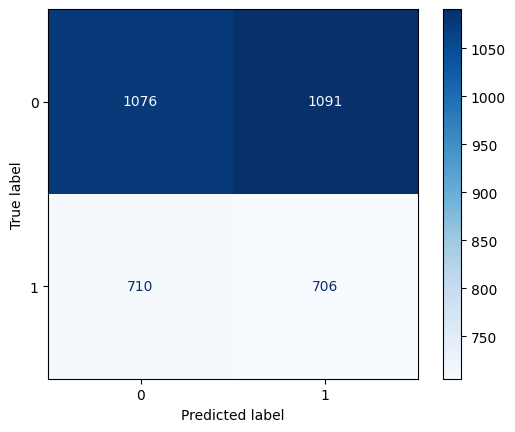

In [27]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM()
clf.fit(X_train_bots)

X_test_df = X_test_df.fillna(1)

y_pred = clf.predict(X_test_df)
print(any(y_pred == 1))
y_pred[y_pred == -1] = 0

print_metrics(y_test_preprocessed, y_pred)

### RandomForest

In [19]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_preprocessed, y_train_preprocessed_np)

RandomForestClassifier(random_state=42)

In [20]:
predictions = rfc.predict(X_test_preprocessed_np)

Matthews correlation coefficient: -0.1494478668294213
Recall: 0.7711686494051785
Precision: 0.3649006622516556
F1 score: 0.49539222297145424
Accuracy: 0.3763888888888889


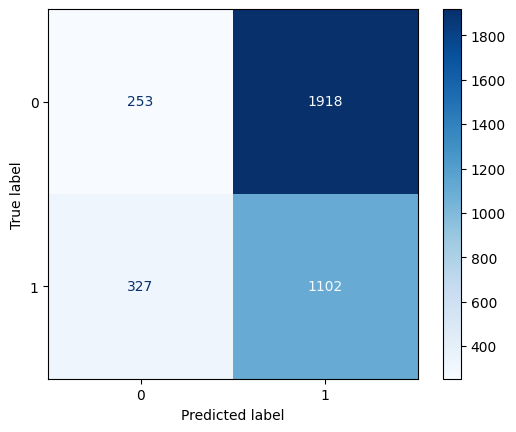

In [21]:
print_metrics(y_test_preprocessed, predictions)

## Different features approach

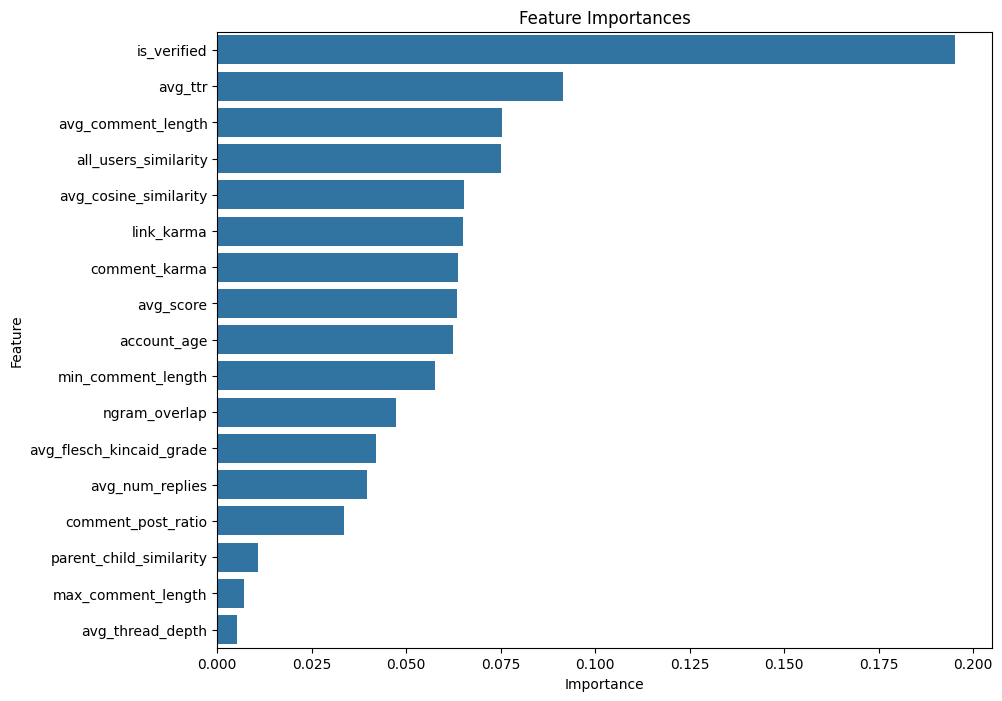

In [32]:
import seaborn as sns

feature_importances = rfc.feature_importances_
features = X_train.drop(columns=['username']).columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [33]:
X_train_df = pd.DataFrame(X_train_preprocessed, columns=X_train.drop(columns=['username']).columns)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=X_test.drop(columns=['username']).columns)

In [34]:
def train_model_without_columns(X_train, y_train, X_test, y_test, columns_to_drop=None):
    if columns_to_drop:
        X_train = X_train.drop(columns=columns_to_drop)
        X_test = X_test.drop(columns=columns_to_drop)

    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train, y_train)

    predictions = rfc.predict(X_test)

    print_metrics(y_test, predictions)

    plot_feature_importances(rfc, X_train)

    return rfc


def plot_feature_importances(rfc, X_train):
    feature_importances = rfc.feature_importances_
    features = X_train.columns

    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, color='#FF4500')
    plt.title('Feature Importances')
    plt.show()


### Approach 1

***Training without:***
- *min_comment_length*,
- *max_comment_length*,
- *ngram_overlap*,
- *comment_post_ratio*,


In [35]:
X_train_df.columns, len(X_train_df.columns)

(Index(['link_karma', 'comment_karma', 'account_age', 'is_verified',
        'avg_cosine_similarity', 'all_users_similarity', 'avg_comment_length',
        'max_comment_length', 'min_comment_length', 'comment_post_ratio',
        'avg_thread_depth', 'parent_child_similarity', 'avg_ttr',
        'avg_flesch_kincaid_grade', 'ngram_overlap', 'avg_score',
        'avg_num_replies'],
       dtype='object'),
 17)

Matthews correlation coefficient: 0.22008409774244134
Recall: 0.3792372881355932
Precision: 0.5767991407089151
F1 score: 0.4576054537707712
Accuracy: 0.6447111359196205


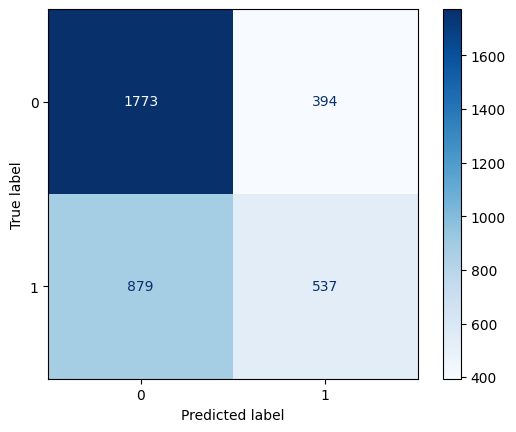

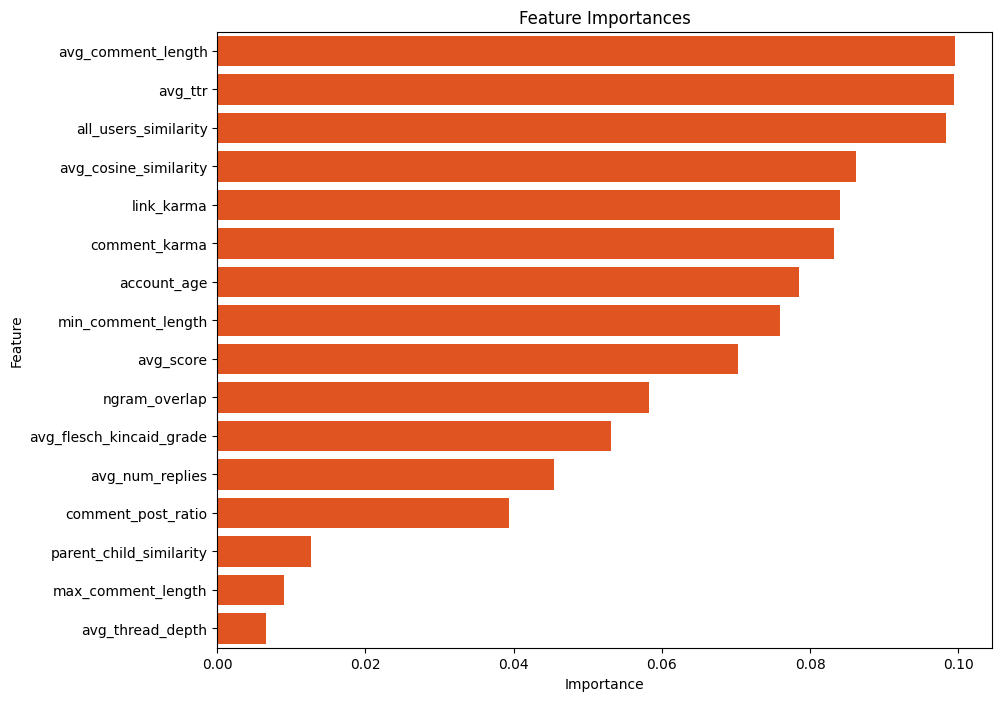

In [36]:
columns_to_drop = [
    "is_verified",
    # "min_comment_length",
    # "max_comment_length",
    # "ngram_overlap",
    # "avg_stickied"
    # "comment_post_ratio",
    # "avg_cosine_similarity",
    # "parent_child_similarity",
]

rfc = train_model_without_columns(
    X_train_df,
    y_train_preprocessed_np,
    X_test_df,
    y_test_preprocessed,
    columns_to_drop,
)

In [27]:
def plot_probabilities_vs_actual(probabilities, y_test):
    plt.figure(figsize=(10, 8))
    
    # Ensure y_test is a 1-dimensional array
    y_test = y_test['is_bot'].values.flatten()
    
    # Ensure probabilities is a 1-dimensional array
    probabilities = probabilities.flatten()
    
    # Separate probabilities based on actual values
    probabilities_is_bot = probabilities[y_test == 1]
    probabilities_not_bot = probabilities[y_test == 0]
    
    # Plot the distributions
    sns.histplot(probabilities_is_bot, kde=True, label='Predicted Probabilities (is_bot=1)', color='blue', bins=50)
    sns.histplot(probabilities_not_bot, kde=True, label='Predicted Probabilities (is_bot=0)', color='red', bins=50)
    
    plt.title('Predicted Probabilities Distribution for is_bot=1 and is_bot=0')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def train_prob_model_without_columns(X_train, y_train, X_test, y_test, columns_to_drop=None, threshold=0.5):
    if columns_to_drop:
        X_train = X_train.drop(columns=columns_to_drop)
        X_test = X_test.drop(columns=columns_to_drop)

    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    rfc.fit(X_train, y_train)

    # Predict probabilities
    probabilities = rfc.predict_proba(X_test)[:, 1]

    # Apply threshold
    predictions = (probabilities >= threshold).astype(int)

    print_metrics(y_test, predictions)

    # plot_feature_importances(rfc, X_train)

    plot_probabilities_vs_actual(probabilities, y_test)

    return rfc


Matthews correlation coefficient: -0.08388571901691896
Recall: 0.9472477064220184
Precision: 0.3952153110047847
F1 score: 0.5577312626603647
Accuracy: 0.3946395563770795


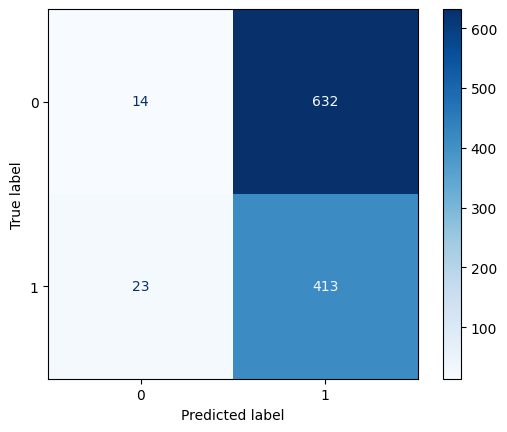

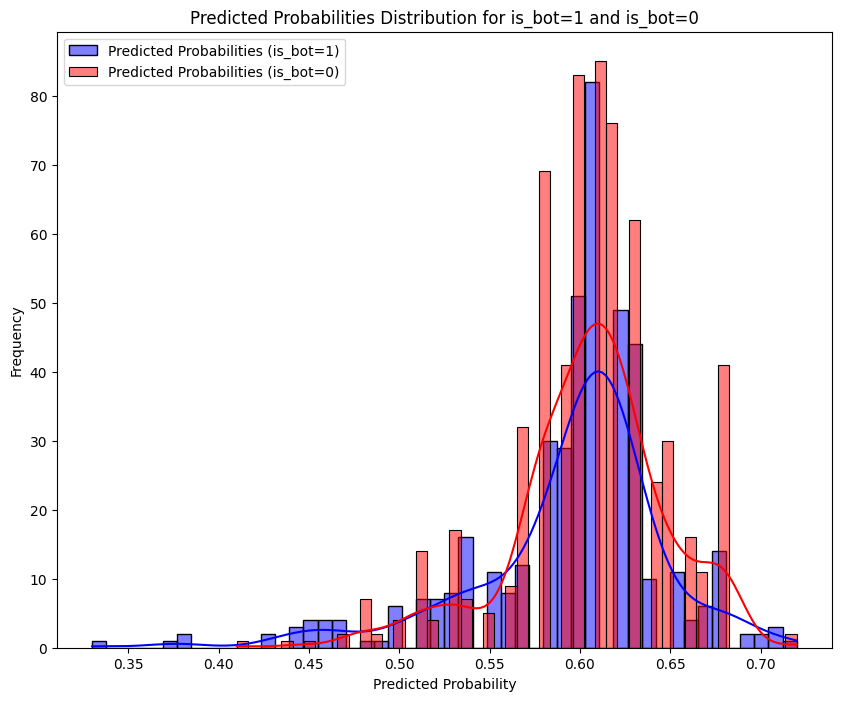

RandomForestClassifier(random_state=42)

In [30]:
columns_to_drop = [
    "min_comment_length",
    "max_comment_length",
    "ngram_overlap",
    # "comment_post_ratio",
    "avg_stickied",
    # 'link_karma',
    # 'comment_karma',
    # 'account_age',
    "parent_child_similarity",
    # "avg_ttr",
]
train_prob_model_without_columns(X_train_df, y_train_preprocessed_np, X_test_df, y_test_preprocessed, columns_to_drop)

In [31]:
from catboost import CatBoostClassifier, Pool


def train_catboost(X_train, y_train, X_test, y_test, columns_to_drop=None):
    if columns_to_drop:
        X_train = X_train.drop(columns=columns_to_drop)
        X_test = X_test.drop(columns=columns_to_drop)

    catboost = CatBoostClassifier(iterations=100, verbose=10, random_state=42, eval_metric='F1')
    catboost.fit(X_train, y_train)

    predictions = catboost.predict(X_test)

    print_metrics(y_test, predictions)

    feature_importances = catboost.get_feature_importance(Pool(X_train, label=y_train))
    features = X_train.columns

    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances')
    plt.show()

    return catboost

def train_prob_catboost(X_train, y_train, X_test, y_test, columns_to_drop=None, threshold=0.5):
    if columns_to_drop:
        X_train = X_train.drop(columns=columns_to_drop)
        X_test = X_test.drop(columns=columns_to_drop)

    catboost = CatBoostClassifier(iterations=100, verbose=False, random_state=42, eval_metric='F1')
    catboost.fit(X_train, y_train)

    probabilities = catboost.predict_proba(X_test)[:, 1]

    # Apply threshold
    predictions = (probabilities >= threshold).astype(int)

    print_metrics(y_test, predictions)

    # plot_feature_importances(rfc, X_train)

    plot_probabilities_vs_actual(probabilities, y_test)

    return rfc


Learning rate set to 0.158171
0:	learn: 0.3808718	total: 163ms	remaining: 16.1s
10:	learn: 0.3255814	total: 209ms	remaining: 1.69s
20:	learn: 0.3800090	total: 253ms	remaining: 952ms
30:	learn: 0.4028331	total: 298ms	remaining: 663ms
40:	learn: 0.4443486	total: 341ms	remaining: 490ms
50:	learn: 0.4575107	total: 380ms	remaining: 365ms
60:	learn: 0.4755068	total: 443ms	remaining: 283ms
70:	learn: 0.4949917	total: 494ms	remaining: 202ms
80:	learn: 0.5101618	total: 528ms	remaining: 124ms
90:	learn: 0.5315940	total: 569ms	remaining: 56.2ms
99:	learn: 0.5560466	total: 608ms	remaining: 0us
Matthews correlation coefficient: -0.09668157792574972
Recall: 0.8279816513761468
Precision: 0.3844515441959531
F1 score: 0.525090909090909
Accuracy: 0.39648798521256934


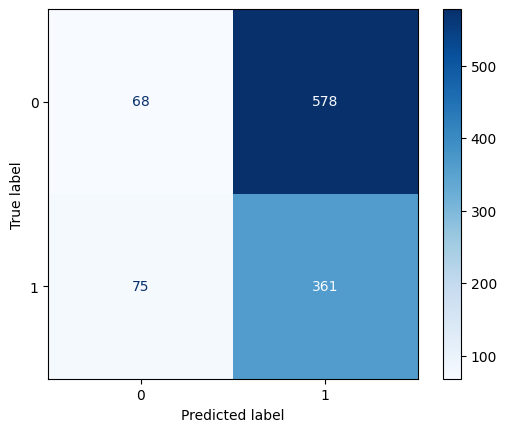

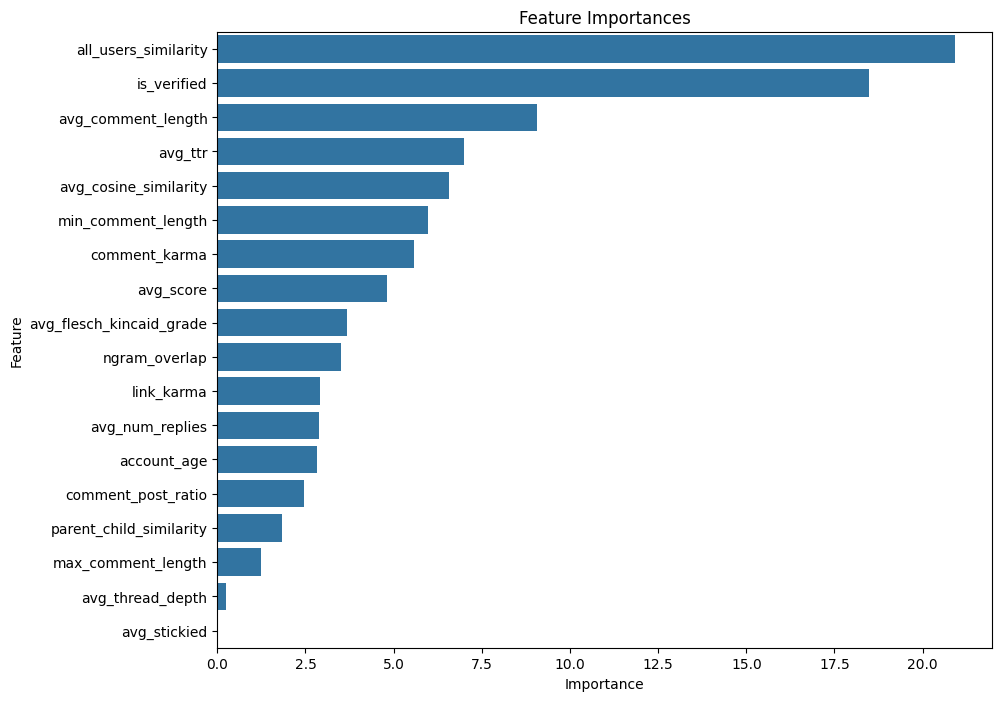

In [32]:
train_catboost(X_train_df, y_train_preprocessed_np, X_test_df, y_test_preprocessed)

Learning rate set to 0.158171
0:	learn: 0.2879005	total: 3.93ms	remaining: 389ms
10:	learn: 0.3272214	total: 53.7ms	remaining: 435ms
20:	learn: 0.3794502	total: 91.6ms	remaining: 345ms
30:	learn: 0.4065400	total: 136ms	remaining: 303ms
40:	learn: 0.4286964	total: 172ms	remaining: 247ms
50:	learn: 0.4472210	total: 209ms	remaining: 201ms
60:	learn: 0.4726811	total: 257ms	remaining: 164ms
70:	learn: 0.4905660	total: 299ms	remaining: 122ms
80:	learn: 0.5072644	total: 332ms	remaining: 77.9ms
90:	learn: 0.5320277	total: 369ms	remaining: 36.5ms
99:	learn: 0.5530547	total: 399ms	remaining: 0us
Matthews correlation coefficient: -0.06118587099432029
Recall: 0.8256880733944955
Precision: 0.39045553145336226
F1 score: 0.5301914580265096
Accuracy: 0.41035120147874304


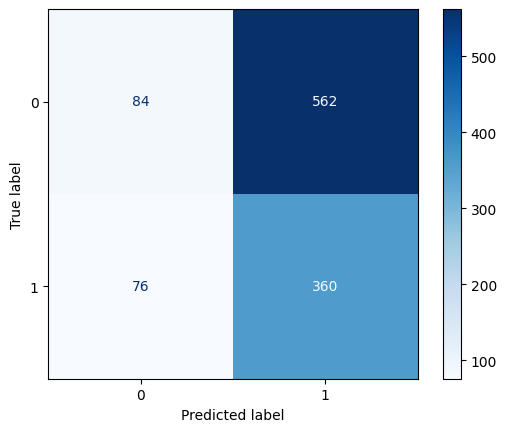

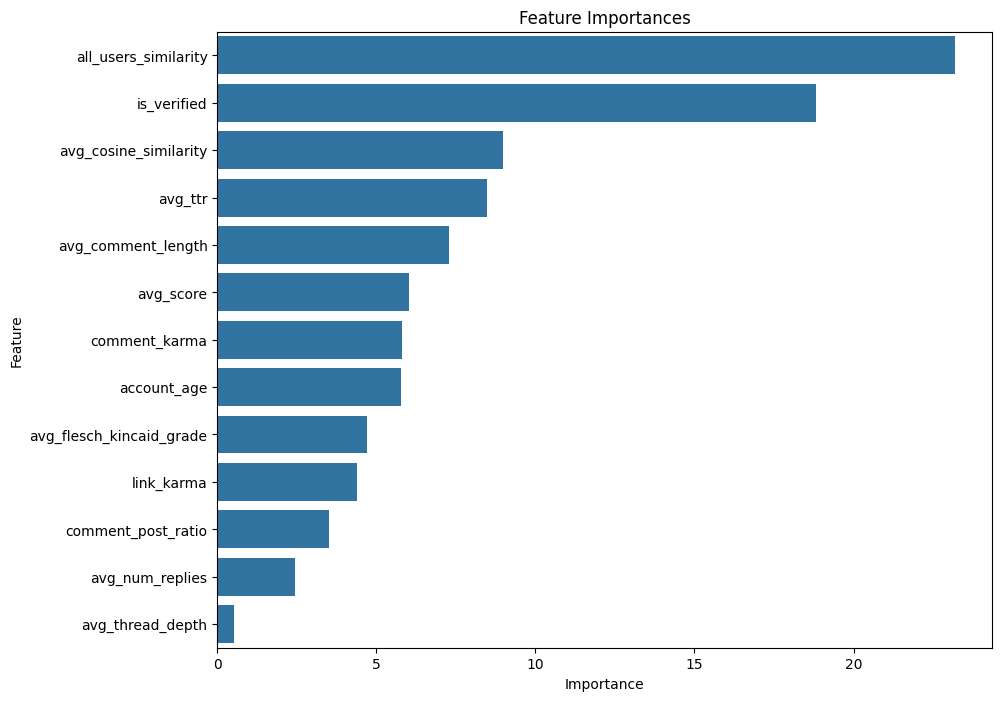

In [33]:
train_catboost(X_train_df, y_train_preprocessed_np, X_test_df, y_test_preprocessed, columns_to_drop)

Matthews correlation coefficient: -0.06232394758636418
Recall: 0.8004587155963303
Precision: 0.3890746934225195
F1 score: 0.5236309077269318
Accuracy: 0.41312384473197783


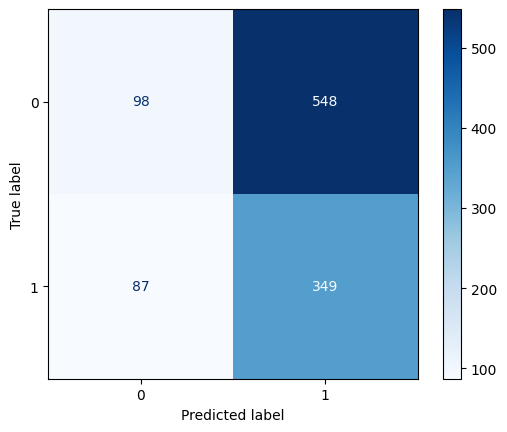

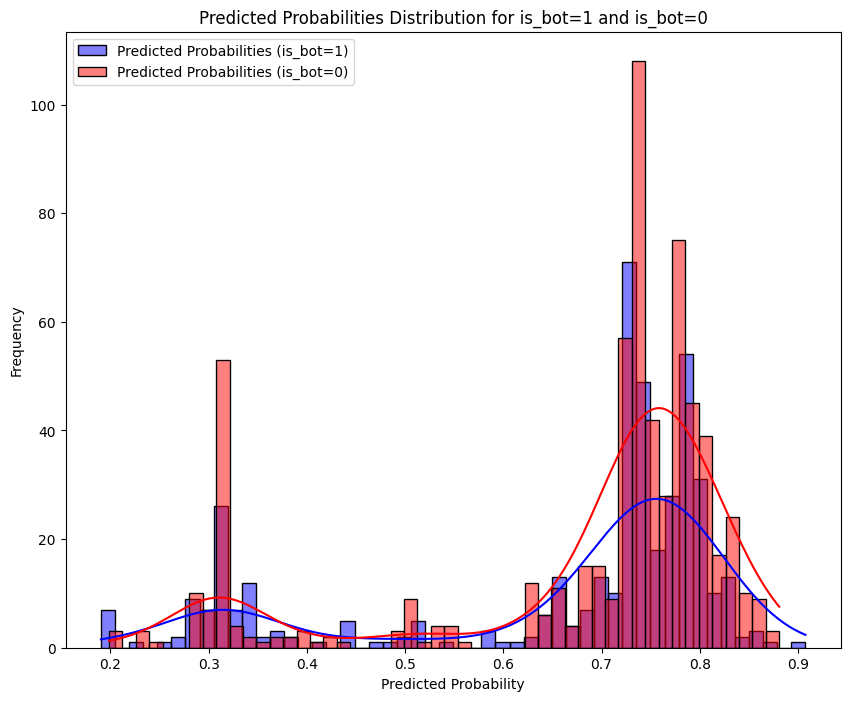

RandomForestClassifier(random_state=42)

In [34]:
columns_to_drop = [
    "min_comment_length",
    "max_comment_length",
    "ngram_overlap",
    "comment_post_ratio",
    'link_karma',
    # 'comment_karma',
    # 'account_age',
    # "parent_child_similarity",
    "avg_ttr",
]

train_prob_catboost(X_train_df, y_train_preprocessed_np, X_test_df, y_test_preprocessed, columns_to_drop)

### Approach 2

***Training without:***
- *min_comment_length*,
- *max_comment_length*,
- *ngram_overlap*,
- *comment_post_ratio*,
- *link_karma*, 
- *comment_karma*, 
- *account_age*,


In [35]:
X_train.columns

Index(['username', 'link_karma', 'comment_karma', 'account_age', 'is_verified',
       'avg_cosine_similarity', 'all_users_similarity', 'avg_comment_length',
       'max_comment_length', 'min_comment_length', 'comment_post_ratio',
       'avg_thread_depth', 'parent_child_similarity', 'avg_ttr',
       'avg_flesch_kincaid_grade', 'ngram_overlap', 'avg_score',
       'avg_num_replies', 'avg_stickied'],
      dtype='object')

Matthews correlation coefficient: -0.0644821109903496
Recall: 0.8715596330275229
Precision: 0.39215686274509803
F1 score: 0.5409252669039146
Accuracy: 0.40388170055452866


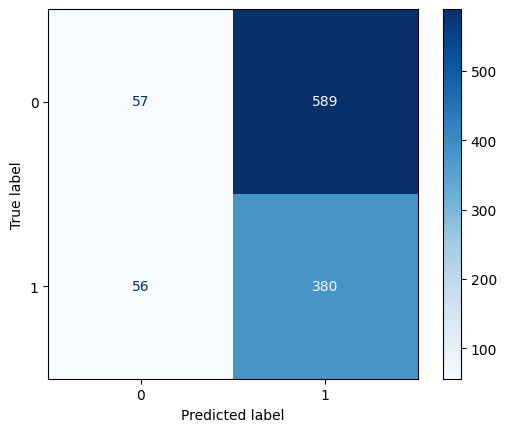

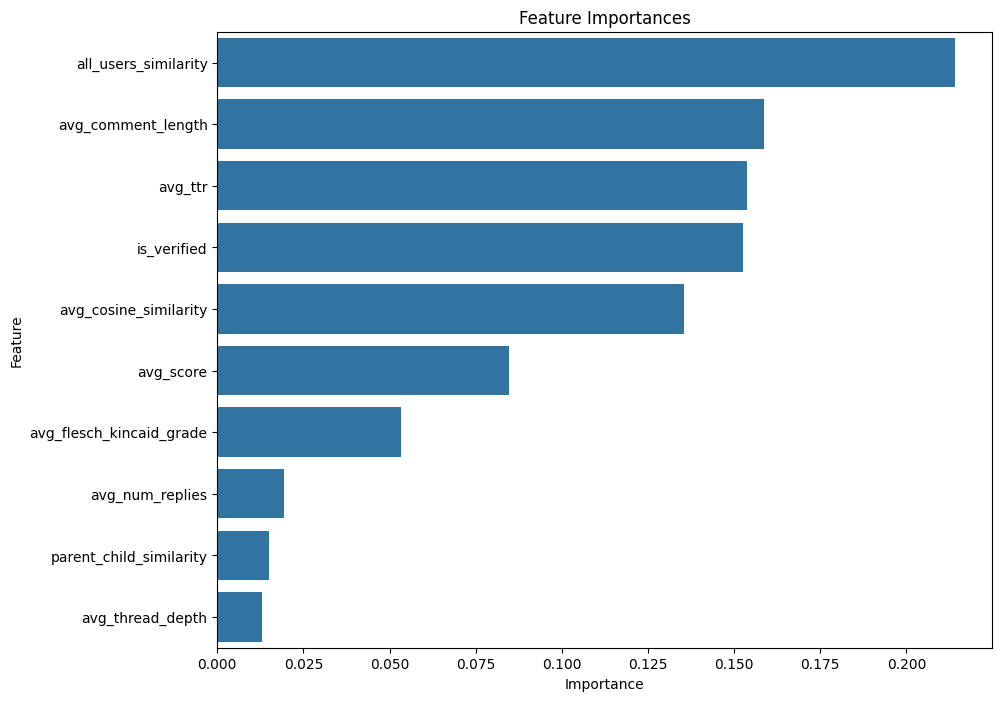

In [ ]:
columns_to_drop = [
    "min_comment_length",
    "max_comment_length",
    "ngram_overlap",
    "comment_post_ratio",
    'link_karma',
    'comment_karma',
    'account_age',
    "avg_stickied",
    # "parent_child_similarity",
    # "avg_ttr",
]

rfc = train_model_without_columns(
    X_train_df,
    y_train_preprocessed_np,
    X_test_df,
    y_test_preprocessed,
    columns_to_drop,
)

Learning rate set to 0.158171
0:	learn: 0.3736548	total: 3.23ms	remaining: 320ms
10:	learn: 0.3397466	total: 46.8ms	remaining: 379ms
20:	learn: 0.3496048	total: 89.3ms	remaining: 336ms
30:	learn: 0.3960485	total: 119ms	remaining: 266ms
40:	learn: 0.4074238	total: 149ms	remaining: 214ms
50:	learn: 0.4262582	total: 175ms	remaining: 168ms
60:	learn: 0.4401211	total: 202ms	remaining: 129ms
70:	learn: 0.4554371	total: 236ms	remaining: 96.2ms
80:	learn: 0.4807692	total: 266ms	remaining: 62.5ms
90:	learn: 0.5024631	total: 301ms	remaining: 29.8ms
99:	learn: 0.5143325	total: 327ms	remaining: 0us
Matthews correlation coefficient: -0.11439685269732759
Recall: 0.8486238532110092
Precision: 0.38341968911917096
F1 score: 0.5281941470378301
Accuracy: 0.38909426987060997


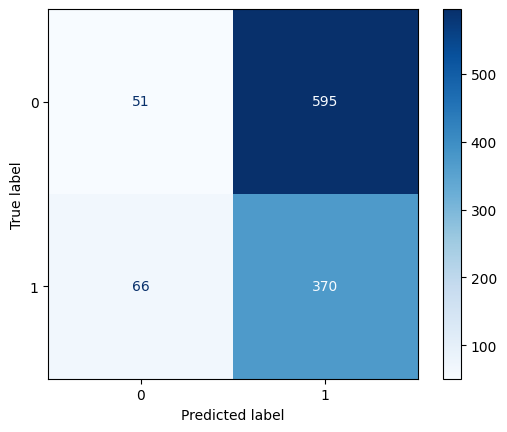

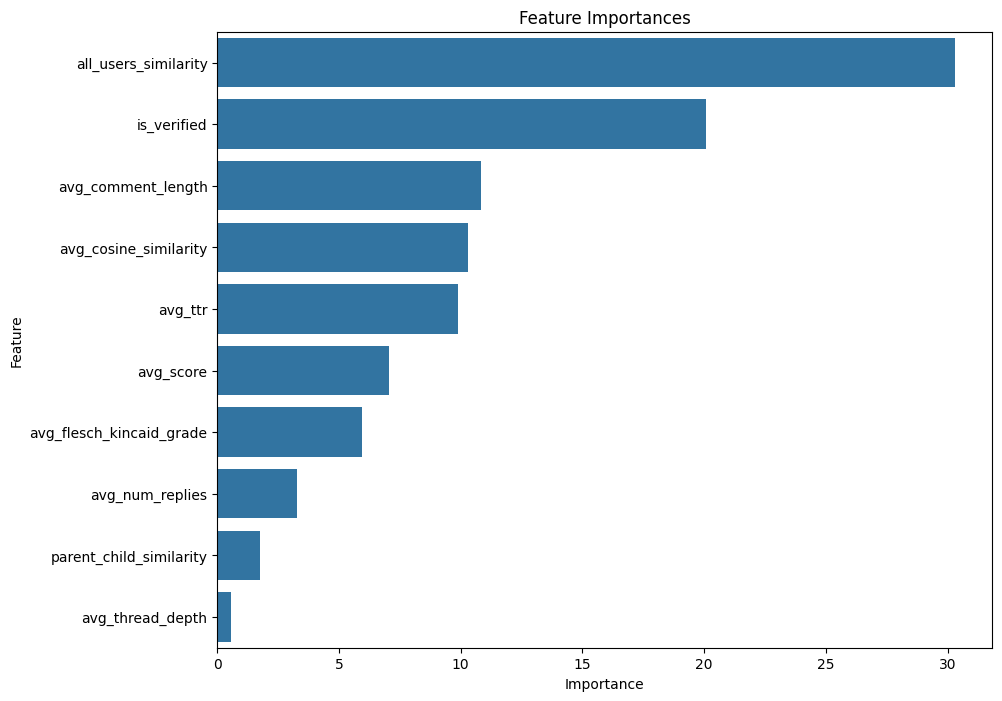

In [39]:
catboost = train_catboost(X_train_df, y_train_preprocessed_np, X_test_df, y_test_preprocessed, columns_to_drop)

## PCA analysis

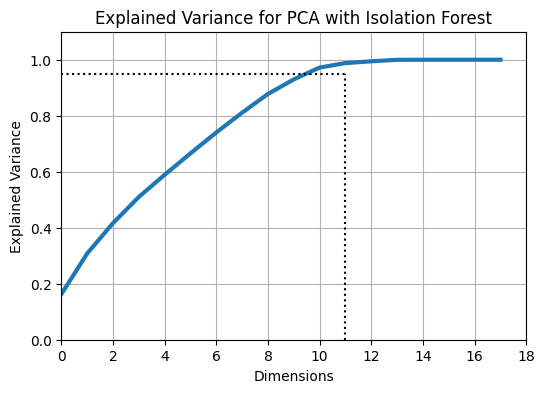

Isolation Forest osiąga ponad 0.95% wariancji dla 11 wymiarów


In [40]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_preprocessed)

reduction_factor = 0.95

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= reduction_factor) + 1

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, X_train_preprocessed.shape[1], 0, 1.1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, reduction_factor], "k:")
plt.plot([0, d], [reduction_factor, reduction_factor], "k:")
plt.grid(True)
plt.title("Explained Variance for PCA with Isolation Forest")
plt.show()
print(f"Isolation Forest osiąga ponad {reduction_factor}% wariancji dla {d} wymiarów")



In [41]:
def plot_pca_3d(X, y, title='3D PCA'):
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    fig.colorbar(scatter, label='Target')
    plt.show()


def plot_pca_2d(X, y, title='2D PCA'):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Target')
    plt.show()

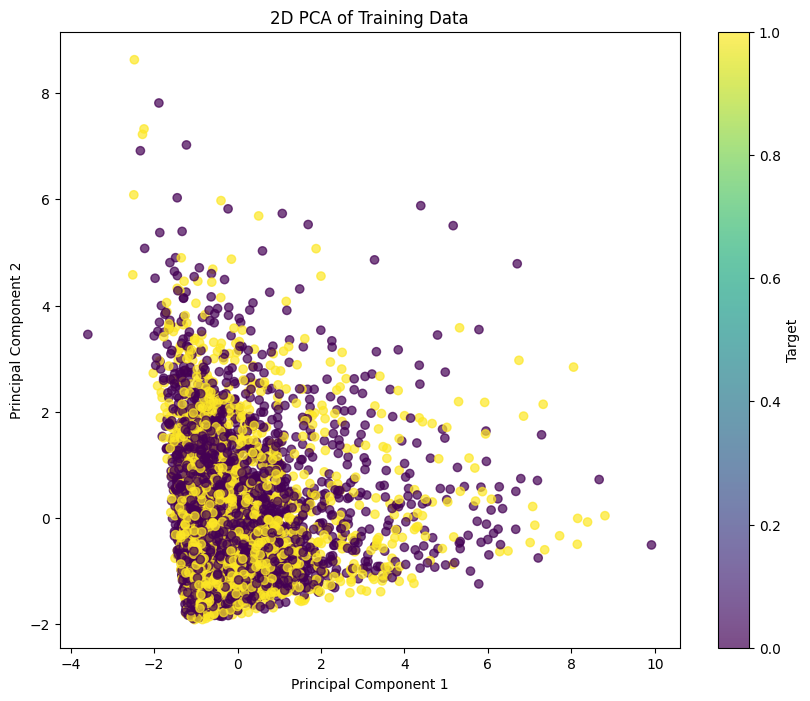

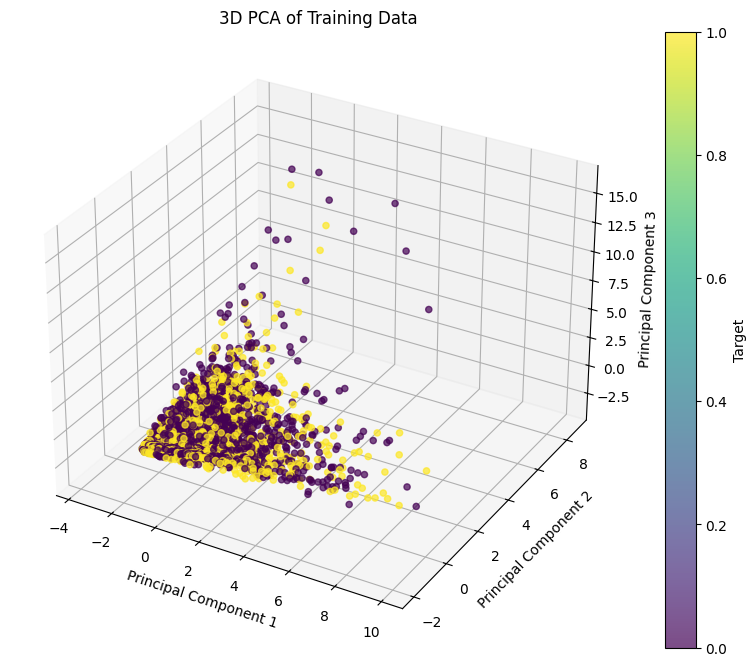

In [42]:
plot_pca_2d(X_train_df, y_train_preprocessed_np, title='2D PCA of Training Data')
plot_pca_3d(X_train_df, y_train_preprocessed_np, title='3D PCA of Training Data')

## Optuna

### By Mcc

In [24]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 2_000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', [1, 2, 5, 10, None, 'sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    y_pred = cross_val_predict(clf, X_train_preprocessed, y_train_preprocessed, cv=3, n_jobs=-1)
    mcc = matthews_corrcoef(y_train_preprocessed, y_pred)
    return mcc


In [25]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-07 10:00:43,462] A new study created in memory with name: no-name-cdd67fcf-7df1-4e57-a278-7e4b3318e632
[I 2024-11-07 10:00:53,794] Trial 3 finished with value: 0.25115822313954944 and parameters: {'n_estimators': 626, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 2, 'criterion': 'log_loss'}. Best is trial 3 with value: 0.25115822313954944.
[I 2024-11-07 10:01:04,595] Trial 4 finished with value: 0.2568988127703969 and parameters: {'n_estimators': 1190, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 16, 'max_features': 5, 'criterion': 'entropy'}. Best is trial 4 with value: 0.2568988127703969.
[I 2024-11-07 10:01:10,164] Trial 6 finished with value: 0.2542366736484965 and parameters: {'n_estimators': 271, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 10, 'criterion': 'gini'}. Best is trial 4 with value: 0.2568988127703969.
[I 2024-11-07 10:01:18,357] Trial 1 finished with value: 0.2413651171281

In [27]:
print("Best hyperparameters: ", study.best_params)

best_params = study.best_params
best_clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)
best_clf.fit(X_train_preprocessed, y_train_preprocessed.values.ravel())

Best hyperparameters:  {'n_estimators': 313, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}


RandomForestClassifier(max_depth=12, min_samples_leaf=3, min_samples_split=9,
                       n_estimators=313, random_state=42)

Matthews correlation coefficient: 0.03390199575799733
Recall: 0.5645161290322581
Precision: 0.4231433506044905
F1 score: 0.4837117472852912
Accuracy: 0.5084586466165414


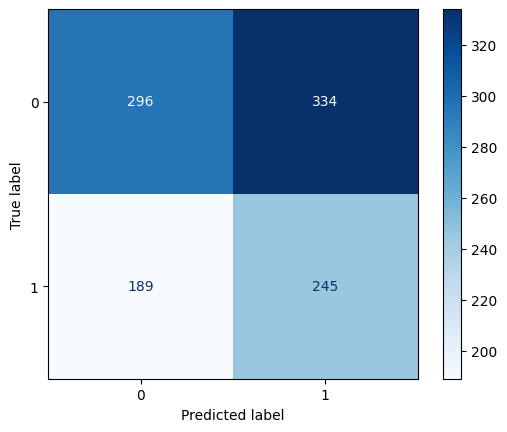

In [29]:
best_pred = best_clf.predict(X_test_preprocessed_np)
print_metrics(y_test_preprocessed, best_pred)

In [31]:
optuna.visualization.plot_optimization_history(study)

In [32]:
optuna.visualization.plot_param_importances(study)

In [33]:
optuna.visualization.plot_parallel_coordinate(study)

In [34]:
optuna.visualization.plot_slice(study)

### By F1

In [35]:
def objective_f1(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 2_000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', [1, 2, 5, 10, None, 'sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    y_pred = cross_val_predict(clf, X_train_preprocessed, y_train_preprocessed, cv=3, n_jobs=-1)
    f1 = f1_score(y_train_preprocessed, y_pred)
    return f1


In [ ]:
study_f1 = optuna.create_study(direction='maximize')
study_f1.optimize(objective_f1, n_trials=100, n_jobs=-1)

[I 2024-11-07 10:45:13,599] A new study created in memory with name: no-name-766d4c77-18dc-4937-bd6e-26d1b79d0bef
[I 2024-11-07 10:45:23,714] Trial 0 finished with value: 0.1725780836421387 and parameters: {'n_estimators': 802, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 1, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.1725780836421387.
[I 2024-11-07 10:45:26,312] Trial 4 finished with value: 0.17030335284725917 and parameters: {'n_estimators': 1316, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.1725780836421387.
[I 2024-11-07 10:45:26,591] Trial 5 finished with value: 0.1916105644743656 and parameters: {'n_estimators': 48, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 1, 'criterion': 'log_loss'}. Best is trial 5 with value: 0.1916105644743656.
[I 2024-11-07 10:45:45,829] Trial 6 finished with value: 0.35482436638506

In [ ]:
print("Best hyperparameters F1: ", study_f1.best_params)

best_params_f1 = study_f1.best_params
best_clf_f1 = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)
best_clf_f1.fit(X_train_preprocessed, y_train_preprocessed.values.ravel())

In [ ]:
best_pred_f1 = best_clf_f1.predict(X_test_preprocessed_np)
print_metrics(y_test_preprocessed, best_pred_f1)

In [ ]:
optuna.visualization.plot_optimization_history(study_f1)

In [ ]:
optuna.visualization.plot_param_importances(study_f1)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_f1)

In [ ]:
optuna.visualization.plot_slice(study_f1)